# Comparación entre bandas SeaWiFS(490) y MODIS(10)

Primero cargaremos las librerias necesarias.

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
from scipy.stats import kde

import seaborn as sns
plt.style.use('seaborn')

Cargaremos en memoria los datos de los sensores para enero de 2003. Los archivos fueron modificados para representar la pura matriz de datos.

In [2]:
# Para el sensor SeaWiFS.

with open('Composicion_(Lt_490).txt') as archivo_seawifs:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_seawifs.readline()
    # Separamos los datos en una matriz.
    datos_seawifs = np.array([archivo_seawifs.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_seawifs = datos_seawifs.ravel()
datos_seawifs = np.array([float(dat) for dat in datos_seawifs])

In [3]:
# Para el sensor MODIS. Es lo mismo pero con otro archivo.

with open('Composicion_(Band 10).txt') as archivo_modis:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_modis.readline()
    # Separamos los datos en una matriz.
    datos_modis = np.array([archivo_modis.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_modis = datos_modis.ravel()
datos_modis = np.array([float(dat) for dat in datos_modis])

Primero veremos la variación entre los valores de cada pixel

In [4]:
media_seawifs = np.mean(datos_seawifs)
media_modis = np.mean(datos_modis)

desv_est_seawifs = np.std(datos_seawifs)
desv_est_modis = np.std(datos_modis)

print("Promedio de los datos del SeaWiFS: {}.".format(media_seawifs))
print("Promedio de los datos del MODIS: {}.".format(media_modis))

print("Desviación estándar de los datos del SeaWiFS: {}.".format(desv_est_seawifs))
print("Desviación estándar de los datos del MODIS: {}.".format(desv_est_modis))

Promedio de los datos del SeaWiFS: 44.80587750011788.
Promedio de los datos del MODIS: 42.81177717478429.
Desviación estándar de los datos del SeaWiFS: 5.840954987606979.
Desviación estándar de los datos del MODIS: 3.939091475421393.


Ahora limpiaremos rudimentariamente los datos.

In [5]:
tolerancia = 3

for i in range(datos_seawifs.size):
    if np.abs(datos_seawifs[i] - media_seawifs) > tolerancia:
        datos_seawifs[i] = np.mean(datos_seawifs[0:i])

datos_seawifs

array([43.2616, 43.211 , 43.211 , ..., 43.6696, 43.6732, 43.6555])

In [6]:
tolerancia = 3

for i in range(datos_modis.size):
    if np.abs(datos_modis[i] - media_modis) > tolerancia:
        datos_modis[i] = np.mean(datos_modis[0:i])

datos_modis

array([41.1685, 41.1685, 41.1422, ..., 42.5366, 42.5614, 42.5545])

In [7]:
np.max(datos_modis)

45.7937

Examinemos que tan diferentes son los valores para cada pixel.

In [8]:
datos_comb = abs(datos_seawifs - datos_modis)
ma_comb = np.mean(datos_comb)
desv_est_comb = np.std(datos_comb)

print("Media aritmética de las distancias entre pixeles: {}".format(ma_comb))
print("Desviación estándar de las distancias entre pixeles: {}.".format(desv_est_comb))

Media aritmética de las distancias entre pixeles: 1.5215700210993077
Desviación estándar de las distancias entre pixeles: 0.5651985211125994.


Ahora calculamos la regresión lineal para los datos de ambos sensores.

In [9]:
# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs, datos_modis, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs, datos_modis)

Y graficamos los resultados.

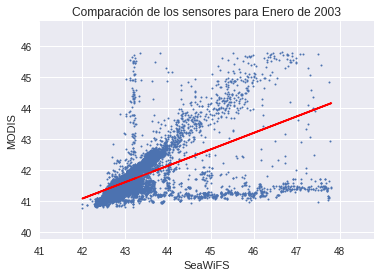

In [12]:
plt.plot(datos_seawifs, datos_modis, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs) - 1, np.max(datos_seawifs) + 1)
plt.ylim(np.min(datos_modis) - 1, np.max(datos_modis) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Enero de 2003")

#plt.text(4, 0, 'r = {0:2.3f}'.format(r[0,1]))
#plt.text(4, 3, 'Y = {0:2.3f} X + {1:2.3f}'.format(a, b))

# El ajuste calculado.
plt.plot(datos_seawifs, a * datos_seawifs + b,"r")

In [13]:
print("r = {0:2.3f}".format(r[0,1]))
print("Y = {0:2.3f} X + {1:2.3f}".format(a, b))

r = 0.567
Y = 0.531 X + 18.785


## Otras formas de verlo

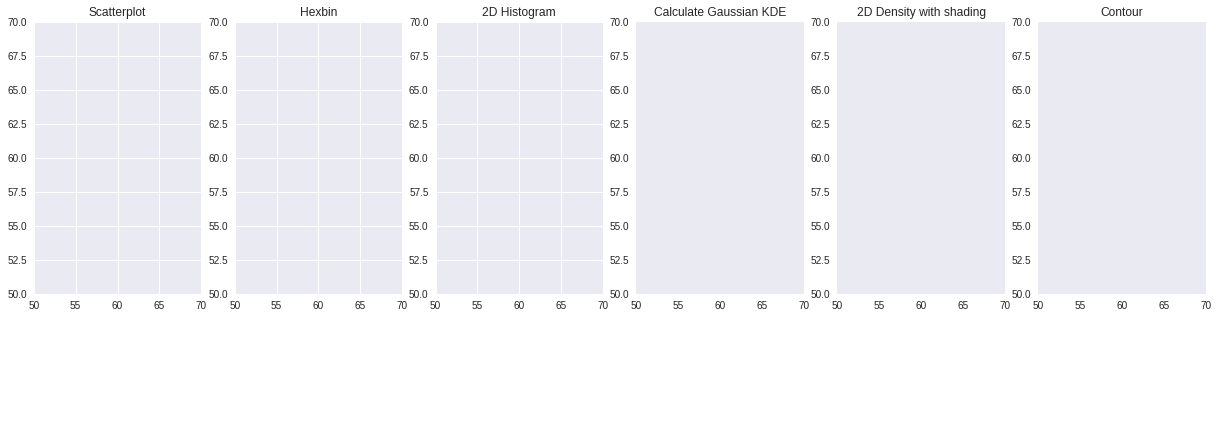

In [14]:
v=[50,70,50,70]

# Create a figure with 6 plot areas
fig, axes = plt.subplots(ncols=6, nrows=1, figsize=(21, 5))

x , y= datos_seawifs, datos_modis
# Everything sarts with a Scatterplot
axes[0].set_title('Scatterplot')
axes[0].axis(v)
axes[0].plot(x, y, 'ko')
# As you can see there is a lot of overplottin here!
 
# Thus we can cut the plotting window in several hexbins
nbins = 20
axes[1].set_title('Hexbin')
axes[1].axis(v)
axes[1].hexbin(x, y, gridsize=nbins, cmap="jet")

 
# 2D Histogram
axes[2].set_title('2D Histogram')
axes[2].hist2d(x, y, bins=nbins, cmap="jet")
axes[2].axis(v)
 
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
k = kde.gaussian_kde((x,y))
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# plot a density
axes[3].set_title('Calculate Gaussian KDE')
axes[3].axis(v)
axes[3].pcolormesh(xi, yi, zi.reshape(xi.shape), cmap="jet")
 
# add shading
axes[4].set_title('2D Density with shading')
axes[4].axis(v)
axes[4].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="jet")
 
# contour
axes[5].set_title('Contour')
axes[5].axis(v)
axes[5].pcolormesh(xi, yi, zi.reshape(xi.shape), shading='gouraud', cmap="jet")
axes[5].contour(xi, yi, zi.reshape(xi.shape) )


### Comparación para el mes de febrero

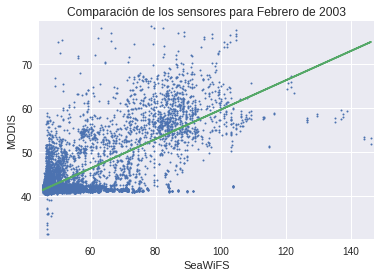

In [31]:
# Para el sensor SeaWiFS.

with open('FEBRERO_2003/SeaWiFS/3_Bandas/Composicion (Lt_490).txt') as archivo_seawifs:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_seawifs.readline()
    # Separamos los datos en una matriz.
    datos_seawifs = np.array([archivo_seawifs.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_seawifs = datos_seawifs.ravel()
datos_seawifs_feb = np.array([float(dat) for dat in datos_seawifs])

# Para el sensor MODIS. Es lo mismo pero con otro archivo.

with open('FEBRERO_2003/MODIS/3_Bandas/Composicion (B10).txt') as archivo_modis:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_modis.readline()
    # Separamos los datos en una matriz.
    datos_modis = np.array([archivo_modis.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_modis = datos_modis.ravel()
datos_modis_feb = np.array([float(dat) for dat in datos_modis])

# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs_feb, datos_modis_feb, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs_feb, datos_modis_feb)

plt.plot(datos_seawifs_feb, datos_modis_feb, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs_feb) - 1, np.max(datos_seawifs_feb) + 1)
plt.ylim(np.min(datos_modis_feb) - 1, np.max(datos_modis_feb) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Febrero de 2003")

# El ajuste calculado.
plt.plot(datos_seawifs_feb, a * datos_seawifs_feb + b)

In [32]:
print("r = {0:2.3f}".format(r[0,1]))
print("Y = {0:2.3f} X + {1:2.3f}".format(a, b))

r = 0.765
Y = 0.334 X + 26.277


#### Varianza entre los datos

In [34]:
media_seawifs_feb = np.mean(datos_seawifs_feb)
media_modis_feb = np.mean(datos_modis_feb)

desv_est_seawifs_feb = np.std(datos_seawifs_feb)
desv_est_modis_feb = np.std(datos_modis_feb)

tolerancia = 5

for i in range(datos_seawifs_feb.size):
    if np.abs(datos_seawifs_feb[i] - media_seawifs_feb) > tolerancia:
        datos_seawifs_feb[i] = np.mean(datos_seawifs_feb[0:i])

tolerancia = 3

for i in range(datos_modis_feb.size):
    if np.abs(datos_modis_feb[i] - media_modis_feb) > tolerancia:
        datos_modis_feb[i] = np.mean(datos_modis_feb[0:i])
        
print("Datos del SeaWiFS para febrero: {}".format(datos_seawifs_feb))
print("Datos del MODIS para febrero: {}".format(datos_modis_feb))

Datos del SeaWiFS para febrero: [46.7706 46.7706 47.6433 ... 46.4078 46.4152 46.8293]
Datos del MODIS para febrero: [40.9027 40.9476 41.0417 ... 41.8585 41.8902 41.9314]


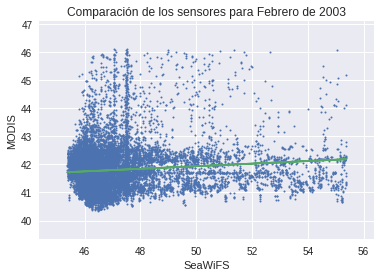

In [35]:
# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs_feb, datos_modis_feb, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs_feb, datos_modis_feb)

plt.plot(datos_seawifs_feb, datos_modis_feb, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs_feb) - 1, np.max(datos_seawifs_feb) + 1)
plt.ylim(np.min(datos_modis_feb) - 1, np.max(datos_modis_feb) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Febrero de 2003")

# El ajuste calculado.
plt.plot(datos_seawifs_feb, a * datos_seawifs_feb + b)

In [36]:
print("r = {0:2.3f}".format(r[0,1]))
print("Y = {0:2.3f} X + {1:2.3f}".format(a, b))

r = 0.109
Y = 0.046 X + 39.626


In [37]:
datos_comb_feb = abs(datos_seawifs_feb - datos_modis_feb)
ma_comb_feb = np.mean(datos_comb_feb)
desv_est_comb_feb = np.std(datos_comb_feb)

print("Media aritmética de las distancias entre pixeles: {}".format(ma_comb_feb))
print("Desviación estándar de las distancias entre pixeles: {}.".format(desv_est_comb_feb))

Media aritmética de las distancias entre pixeles: 5.267112011099661
Desviación estándar de las distancias entre pixeles: 1.77939534944927.


### Comparación para el mes de Marzo

In [ ]:
# Para el sensor SeaWiFS.

with open('MARZO_2003/SeaWiFS/Composicion (Lt_490).txt') as archivo_seawifs:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_seawifs.readline()
    # Separamos los datos en una matriz.
    datos_seawifs = np.array([archivo_seawifs.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_seawifs = datos_seawifs.ravel()
datos_seawifs_mar = np.array([float(dat) for dat in datos_seawifs])

# Para el sensor MODIS. Es lo mismo pero con otro archivo.

with open('MARZO_2003/MODIS/Composicion (B10).txt') as archivo_modis:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_modis.readline()
    # Separamos los datos en una matriz.
    datos_modis = np.array([archivo_modis.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_modis = datos_modis.ravel()
datos_modis_mar = np.array([float(dat) for dat in datos_modis])

# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs_mar, datos_modis_mar, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs_mar, datos_modis_mar)

plt.plot(datos_seawifs_mar, datos_modis_mar, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs_mar) - 1, np.max(datos_seawifs_mar) + 1)
plt.ylim(np.min(datos_modis_mar) - 1, np.max(datos_modis_mar) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Marzo de 2003")

plt.text(4, 0, 'r = {0:2.3f}'.format(r[0,1]))
plt.text(4, 3, 'Y = {0:2.3f} X + {1:2.3f}'.format(a, b))

# El ajuste calculado.
plt.plot(datos_seawifs_mar, a * datos_seawifs_mar + b)

#### Varianza entre los datos

In [ ]:
datos_comb_mar = abs(datos_seawifs_mar - datos_modis_mar)
ma_comb_mar = np.mean(datos_comb_mar)
desv_est_comb_mar = np.std(datos_comb_mar)

print("Media aritmética de las distancias entre pixeles: {}".format(ma_comb_mar))
print("Desviación estándar de las distancias entre pixeles: {}.".format(desv_est_comb_mar))

### Comparación para el mes de Abril

In [ ]:
# Para el sensor SeaWiFS.

with open('ABRIL_2003/SeaWiFS/Composicion (Lt_490).txt') as archivo_seawifs:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_seawifs.readline()
    # Separamos los datos en una matriz.
    datos_seawifs = np.array([archivo_seawifs.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_seawifs = datos_seawifs.ravel()
datos_seawifs_abr = np.array([float(dat) for dat in datos_seawifs])

# Para el sensor MODIS. Es lo mismo pero con otro archivo.

with open('ABRIL_2003/MODIS/Composicion (B10).txt') as archivo_modis:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_modis.readline()
    # Separamos los datos en una matriz.
    datos_modis = np.array([archivo_modis.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_modis = datos_modis.ravel()
datos_modis_abr = np.array([float(dat) for dat in datos_modis])

# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs_abr, datos_modis_abr, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs_abr, datos_modis_abr)

plt.plot(datos_seawifs_abr, datos_modis_abr, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs_abr) - 1, np.max(datos_seawifs_abr) + 1)
plt.ylim(np.min(datos_modis_abr) - 1, np.max(datos_modis_abr) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Abril de 2003")

plt.text(4, 0, 'r = {0:2.3f}'.format(r[0,1]))
plt.text(4, 3, 'Y = {0:2.3f} X + {1:2.3f}'.format(a, b))

# El ajuste calculado.
plt.plot(datos_seawifs_abr, a * datos_seawifs_abr + b,"r")

#### Varianza entre los datos

In [ ]:
datos_comb_abr = abs(datos_seawifs_abr - datos_modis_abr)
ma_comb_abr = np.mean(datos_comb_abr)
desv_est_comb_abr = np.std(datos_comb_abr)

print("Media aritmética de las distancias entre pixeles: {}".format(ma_comb_abr))
print("Desviación estándar de las distancias entre pixeles: {}.".format(desv_est_comb_abr))

### Comparación para el mes de Mayo

In [ ]:
# Para el sensor SeaWiFS.

with open('MAYO_2003/SeaWiFS/Composicion (Lt_490).txt') as archivo_seawifs:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_seawifs.readline()
    # Separamos los datos en una matriz.
    datos_seawifs = np.array([archivo_seawifs.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_seawifs = datos_seawifs.ravel()
datos_seawifs_may = np.array([float(dat) for dat in datos_seawifs])

# Para el sensor MODIS. Es lo mismo pero con otro archivo.

with open('MAYO_2003/MODIS/Composicion (B10).txt') as archivo_modis:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_modis.readline()
    # Separamos los datos en una matriz.
    datos_modis = np.array([archivo_modis.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_modis = datos_modis.ravel()
datos_modis_may = np.array([float(dat) for dat in datos_modis])

# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs_may, datos_modis_may, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs_may, datos_modis_may)

plt.plot(datos_seawifs_may, datos_modis_may, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs_may) - 1, np.max(datos_seawifs_may) + 1)
plt.ylim(np.min(datos_modis_may) - 1, np.max(datos_modis_may) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Mayo de 2003")

plt.text(4, 0, 'r = {0:2.3f}'.format(r[0,1]))
plt.text(4, 3, 'Y = {0:2.3f} X + {1:2.3f}'.format(a, b))

# El ajuste calculado.
plt.plot(datos_seawifs_may, a * datos_seawifs_may + b, "r")

#### Varianza entre los datos

In [ ]:
datos_comb_may = abs(datos_seawifs_may - datos_modis_may)
ma_comb_may = np.mean(datos_comb_may)
desv_est_comb_may = np.std(datos_comb_may)

print("Media aritmética de las distancias entre pixeles: {}".format(ma_comb_may))
print("Desviación estándar de las distancias entre pixeles: {}.".format(desv_est_comb_may))

### Comparación para el mes de Junio

In [ ]:
# Para el sensor SeaWiFS.

with open('JUNIO_2003/SeaWiFS/Composicion (Lt_490).txt') as archivo_seawifs:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_seawifs.readline()
    # Separamos los datos en una matriz.
    datos_seawifs = np.array([archivo_seawifs.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_seawifs = datos_seawifs.ravel()
datos_seawifs_jun = np.array([float(dat) for dat in datos_seawifs])

# Para el sensor MODIS. Es lo mismo pero con otro archivo.

with open('JUNIO_2003/MODIS/Composicion (B10).txt') as archivo_modis:
    for _ in range(5):
        # Ignoramos los primeros 5 renglones del archivo.
        archivo_modis.readline()
    # Separamos los datos en una matriz.
    datos_modis = np.array([archivo_modis.readline().split()
                              for _ in range(127)])

# Desenrrollamos y convertimos a reales.
datos_modis = datos_modis.ravel()
datos_modis_jun = np.array([float(dat) for dat in datos_modis])

# Calculamos los coeficientes del ajuste lineal
a, b = np.polyfit(datos_seawifs_jun, datos_modis_jun, 1)
# Calculamos el coeficiente de correlación
r = np.corrcoef(datos_seawifs_jun, datos_modis_jun)

plt.plot(datos_seawifs_jun, datos_modis_jun, linestyle='', marker='o', markersize=2)

plt.xlim(np.min(datos_seawifs_jun) - 1, np.max(datos_seawifs_jun) + 1)
plt.ylim(np.min(datos_modis_jun) - 1, np.max(datos_modis_jun) + 1)

plt.xlabel("SeaWiFS")
plt.ylabel("MODIS")

plt.title("Comparación de los sensores para Junio de 2003")

plt.text(4, 0, 'r = {0:2.3f}'.format(r[0,1]))
plt.text(4, 3, 'Y = {0:2.3f} X + {1:2.3f}'.format(a, b))

# El ajuste calculado.
plt.plot(datos_seawifs_jun, a * datos_seawifs_jun + b,"r")

#### Varianza entre los datos

In [ ]:
datos_comb_jun = abs(datos_seawifs_jun - datos_modis_jun)
ma_comb_jun = np.mean(datos_comb_jun)
desv_est_comb_jun = np.std(datos_comb_jun)

print("Media aritmética de las distancias entre pixeles: {}".format(ma_comb_jun))
print("Desviación estándar de las distancias entre pixeles: {}.".format(desv_est_comb_jun))

### Se experimenta con la representacion de hexbin

In [ ]:
# Evaluate a gaussian kde on a regular grid of nbins x nbins over data extents
nbins = 300
k = kde.gaussian_kde([datos_seawifs, datos_modis])
xi, yi = np.mgrid[datos_seawifs.min():datos_seawifs.max():nbins*1j, datos_modis.min():datos_modis.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))


In [ ]:
# Make the plot
plt.hexbin(datos_seawifs, datos_modis, gridsize=(300,300),bins="log",cmap="jet")
plt.show()

In [ ]:
# We can control the size of the bins:

plt.hexbin(datos_seawifs, datos_modis, gridsize=(300,300),cmap="jet")
v=[51,70,52,70]
plt.axis(v)
plt.show()


In [ ]:
plt.hexbin(datos_seawifs, datos_modis, gridsize=(300,300),bins="log",cmap="jet")
v=[50,70,50,70]
plt.axis(v)
plt.show()